# 数据集

## 下载数据集

In [1]:
def download():
    import kaggle
    # kaggle competitions download -c house-prices-advanced-regression-techniques
    kaggle.api.authenticate()
    kaggle.api.competition_download_files('house-prices-advanced-regression-techniques', path='data')
    import zipfile
    with zipfile.ZipFile('data/house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
#download()

## 读取数据集

In [2]:
import pandas as pd
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# 取出训练集和测试集的特征，并concat起来
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理

### 归一化
对数值数据进行归一化

In [3]:
# 对all_features中的数值特征进行标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_features[numeric_features])
all_features[numeric_features] = scaler.transform(all_features[numeric_features])

### 填充缺失值

In [4]:
all_features = all_features.fillna(0)

### 独热编码

In [5]:
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)

### 拆分得到train和test的features和labels

In [6]:
import torch
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float32)

### 按8:2的比例拆分训练集

In [7]:
batch_size = 1024
# 按8:2划分训练集和验证集
from torch.utils.data import TensorDataset, DataLoader
num_train = int(n_train * 0.8)
train_dataset = TensorDataset(train_features[:num_train], train_labels[:num_train])
val_dataset = TensorDataset(train_features[num_train:], train_labels[num_train:])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 网络定义
定义一个353 x 256 x 128 x 32 x 1的网络

In [8]:
from torch import nn

# 定义模型
num_inputs = train_features.shape[1]
num_hiddens_1 = 256
num_hiddens_2 = 128
num_hiddens_3 = 64
net = nn.Sequential(nn.Linear(num_inputs, num_hiddens_1),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(num_hiddens_1, num_hiddens_2),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(num_hiddens_2, num_hiddens_3),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(num_hiddens_3, 1))
# 初始化模型参数(泽维尔初始化)
for layer in net:
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)
# 定义对数损失函数
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.clamp(pred, min=1), torch.clamp(actual, min=1)))

loss = RMSLELoss()
trainer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=0.01)

# 网络训练

epoch 1000 , train loss 139.478, val loss 297.164


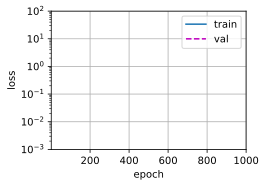

In [9]:
from d2l import torch as d2l
num_epochs = 1000
animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'val']) # 动画绘制
metric_train = d2l.Accumulator(2) # 记录训练损失
metric_val = d2l.Accumulator(2) # 记录验证损失
for epoch in range(num_epochs):
    for X, y in train_loader:
        net.train()
        trainer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        trainer.step()
        metric_train.add(l, X.shape[0])
    net.eval()
    for X, y in val_loader:
        metric_val.add(loss(net(X), y), X.shape[0])
    animator.add(epoch + 1, (metric_train[0] / metric_train[1], metric_val[0] / metric_val[1]))
    print(f'epoch {epoch+1} , train loss {metric_train[0] / metric_train[1]:.3f}, val loss {metric_val[0] / metric_val[1]:.3f}')
    metric_train.reset()
    metric_val.reset()